# Logical shadow tomography: Convergence in number of samples

## Setup

In [1]:
from io import StringIO
from joblib import Parallel, delayed
from typing import Iterable, List
import urllib.request

import matplotlib.pyplot as plt
import numpy as np

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from base.utils import stabilizer_projection_full

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 14})

## Helper functions

In [3]:
def symplectic_to_string(symplectic_pauli: Iterable[int]) -> str:
    assert len(symplectic_pauli) % 2 == 0
    n = len(symplectic_pauli) // 2
    xs = symplectic_pauli[:n]
    zs = symplectic_pauli[n:]

    phase_exponent: int = 0
    pauli: str = ""
    for (x, z) in zip(xs, zs):
        if x and z:
            pauli += "Y"
            phase_exponent += 1
        elif x and not z:
            pauli += "X"
        elif not x and z:
            pauli += "Z"
        elif not x and not z:
            pauli += "I"
        else:
            raise Exception(f"x = {x}, z = {z}.")

    if phase_exponent % 4 == 0:
        phase = ""
    elif phase_exponent % 2 == 0:
        phase = "-"
    else:
        raise Exception(f"phase_exponent = {phase_exponent}.")
    return phase + pauli


def check_matrix_to_stabilizers(check_matrix: Iterable[Iterable[int]]) -> List[str]:
    return [symplectic_to_string(row) for row in check_matrix]

In [4]:
"""Tests."""
assert symplectic_to_string([1, 0]) == "X"
assert symplectic_to_string([0, 1]) == "Z"

assert symplectic_to_string([1, 0, 0, 0]) == "XI"
assert symplectic_to_string([0, 1, 0, 0]) == "IX"
assert symplectic_to_string([0, 0, 1, 0]) == "ZI"
assert symplectic_to_string([0, 0, 0, 1]) == "IZ"
assert symplectic_to_string([1, 1, 0, 0]) == "XX"
assert symplectic_to_string([0, 0, 1, 1]) == "ZZ"
assert symplectic_to_string([1, 0, 0, 1]) == "XZ"
assert symplectic_to_string([0, 1, 1, 0]) == "ZX"
assert symplectic_to_string([1, 1, 1, 1]) == "-YY"

## Codes

In [5]:
def get_code_from_codetables(nqubits: int) -> List[str]:
    """Returns stabilizers for an [[nqubits, 1]] code by grabbing and
    parsing data from http://www.codetables.de/.

    Args:
        nqubits: Number of physical qubits in the code.
    """
    fp = urllib.request.urlopen(
        f"http://www.codetables.de/QECC.php?q=4&n={nqubits}&k=1"
    )
    mybytes = fp.read()
    mystr = mybytes.decode("utf8")
    fp.close()

    lines = mystr.splitlines()
    start = lines.index("    stabilizer matrix:") + 2
    end = start + nqubits - 1

    check_matrix_data = [
        line.strip().lstrip("[").rstrip("]").replace("|", " ")
        for line in lines[start:end]
    ]
    check_matrix = np.genfromtxt(StringIO("\n".join(check_matrix_data)), delimiter=" ")
    return check_matrix_to_stabilizers(check_matrix)

## Experiment

In [6]:
"""Set experimental parameters."""
nmin: int = 10  # Minimum number of physical qubits to use in code.
nmax: int = 60  # Maximum number of physical qubits to use in code.
step: int = 10  # Step between qubit values.

max_num_trajectories: int = 100_000  # Maximum number of trajectories to sample from.

p: float = 0.01  # Depolarizing noise rate.

njobs: int = 4  # Number of parallel workers to use when sampling trajectories.

In [7]:
"""Get codes from provided nqubit values."""
nvalues = np.arange(nmin, nmax + step, step)

codes = {}
for n in nvalues:
    try:
        codes[n] = get_code_from_codetables(n)
    except Exception:
        continue

nvalues = list(codes.keys())
print("Using nvalues:", nvalues)

Using nvalues: [10, 20, 30, 40, 60]


In [8]:
def sample_trajectory(p: float):
    # Initial stabilizer state.
    state = stabilizer_state(*stabilizers)
    gs0 = state.gs.copy()
    ps0 = state.ps.copy()

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Do shadow tomography.
    obs = random_clifford_state(N)
    state.measure(obs)

    gs, ps, _, tmp_PsigmaP = stabilizer_projection_full(
        state.gs, state.ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0
    )
    _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N], ps0[:N], 0)

    return tmp_PsigmaP * tmp, tmp_PsigmaP

In [9]:
"""Run the experiment."""

import time
all_times = []

all_n_values = []
for N, stabilizers in codes.items():
    print(f"Status: On n = {N}", end="\r")

    start = time.monotonic()
    # Note: Variables `N` and `stabilizers` are used by `sample_trajectory`.
    all_values = Parallel(n_jobs=njobs)(
        delayed(sample_trajectory)(p) for _ in range(max_num_trajectories)
    )
    all_times.append(time.monotonic() - start)
    all_n_values.append(all_values)

In [13]:
nsamples_values = np.linspace(100, max_num_trajectories, 1_000, dtype=int)

all_fidelities = []
for (n, all_values) in zip(nvalues, all_n_values):
    fidelities = []
    for nsamples in nsamples_values:
        num, denom = np.sum(all_values[:nsamples], axis=0)
        fid = ((2 ** n + 1) * (num / nsamples) - 1) / (
            (denom / nsamples) * (2 ** n + 1) - 2
        )
        fidelities.append(fid)
    all_fidelities.append(fidelities)

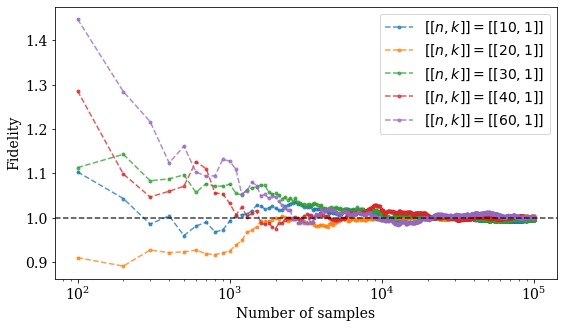

In [33]:
plt.figure(figsize=(9, 5))

for N, fids in zip(nvalues[:], all_fidelities[:]):
    plt.plot(nsamples_values[:], fids[:], "--.", alpha=0.75, label=f"$[[n, k]] = [[{N}, 1]]$")

plt.axhline(1, ls="--", color="black", alpha=0.75)
    
plt.xlabel("Number of samples")
plt.ylabel("Fidelity")
plt.xscale("log")
plt.legend(ncol=1);

# plt.savefig(f"lst_convergence_n_{nmax}_p_{p}.pdf")

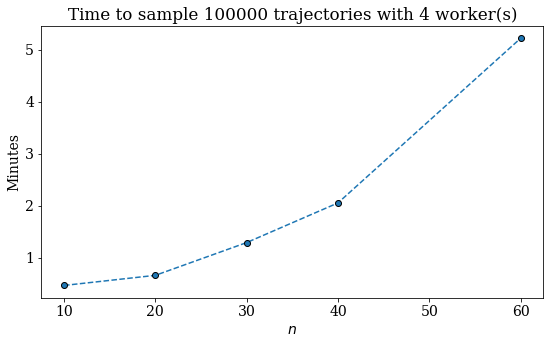

In [12]:
plt.figure(figsize=(9, 5))
plt.plot(nvalues, np.array(all_times) / 60, "--o", mec="black")

plt.xlabel("$n$")
plt.ylabel("Minutes")
plt.title(f"Time to sample {max_num_trajectories} trajectories with {njobs} worker(s)");